

# AAI612: Deep Learning & its Applications

*Notebook 4.3: Graded Assignment: Mini Project I*

<a href="https://colab.research.google.com/github/harmanani/AAI612/blob/main/Week4/Notebook4.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment

In this assessment, you will train a new model that is able to recognize fresh and rotten fruit. You will need to get the model to a validation accuracy of `92%` in order to pass the assessment, though we challenge you to do even better if you can. You will have the use the skills that you learned in the previous exercises. Specifically, we suggest using some combination of transfer learning, data augmentation, and fine tuning.

## The Dataset

In this exercise, you will train a model to recognize fresh and rotten fruits. Download the dataset from [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification). The dataset structure is in the `data/fruits` folder. There are 6 categories of fruits: fresh apples, fresh oranges, fresh bananas, rotten apples, rotten oranges, and rotten bananas. This will mean that your model will require an output layer of 6 neurons to do the categorization successfully. You'll also need to compile the model with `categorical_crossentropy`, as we have more than two categories.

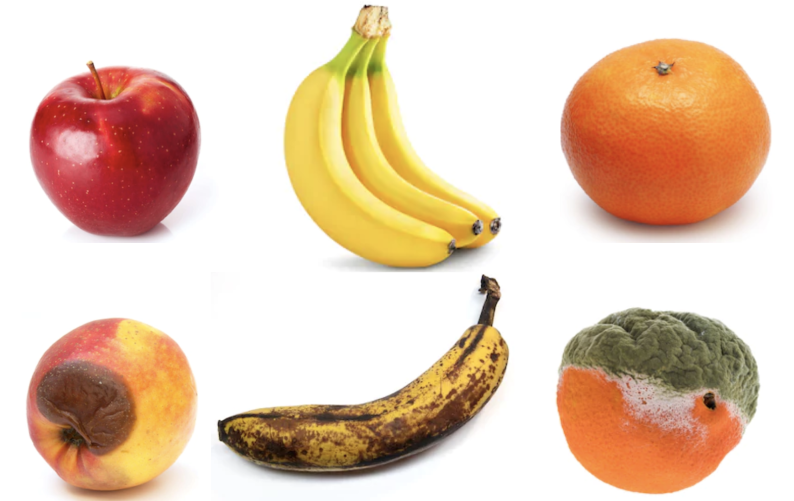<img src="./images/fruits.png" style="width: 600px;">

## Load ImageNet Base Model

Start with a model pretrained on `ImageNet`. Load the model with the correct weights, set an input shape, and choose to remove the last layers of the model. Remember that images have three dimensions: a height, and width, and a number of channels. Because these pictures are in color, there will be three channels for red, green, and blue. We've filled in the input shape for you. This cannot be changed or the assessment will fail. If you need a reference for setting up the pretrained model, please take a look at [Notebook 4.2](https://github.com/harmanani/AAI612/blob/main/Week4/Notebook%204.2.ipynb) where we implemented transfer learning.

In [2]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


In [32]:
def build_model(hp):
    model = keras.applications.VGG16(
        weights = 'imagenet',
        input_shape=(224,224,3),
        include_top=False
    )

    model.trainable = False

    inputs = keras.Input(shape=(224,224,3))
    x = model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    for i in range(hp.Int("dense_layers", 1, 3)):
            x = keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                activation='relu'
            )(x)
            x = keras.layers.Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1))(x)
    
    outputs = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
            ),
            loss=keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=[keras.metrics.CategoricalAccuracy()]
        )
    return model

In [33]:
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    build_model,
    objective="val_categorical_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="fruit_tuner",
    overwrite=True,
)

In [34]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


## Freeze Base Model

Next, we suggest freezing the base model. This is done so that all the learning from the ImageNet dataset does not get destroyed in the initial training.

In [25]:
# Freeze base model
#base_model.trainable = False

## Add Layers to Model

Now it's time to add layers to the pretrained model. Pay close attention to the last dense layer and make sure it has the correct number of neurons to classify the different types of fruit.  You may add more layers than specified below.

In [26]:
'''
# Create inputs with correct shape
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)
'''

"\n# Create inputs with correct shape\ninputs = keras.Input(shape=(224, 224, 3))\n\nx = base_model(inputs, training=False)\n\n# Add pooling layer or flatten layer\nx = keras.layers.GlobalAveragePooling2D()(x)\n\n# Add final dense layer\noutputs = keras.layers.Dense(6, activation = 'softmax')(x)\n\n# Combine inputs and outputs to create model\nmodel = keras.Model(inputs, outputs)\n"

In [27]:
#model.summary()

## Compile Model

Now it's time to compile the model with loss and metrics options. Remember that we're training on a number of different categories, rather than a binary classification problem.

In [28]:
#model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=True) , metrics = [keras.metrics.CategoricalAccuracy()])

## Augment the Data

If you'd like, try to augment the data to improve the dataset. There is also documentation for the [Keras ImageDataGenerator class](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). This step is optional, but it may be helpful to get to 92% accuracy.

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

## Load Dataset

Now it's time to load the train and validation datasets. Pick the right folders, as well as the right `target_size` of the images (it needs to match the height and width input of the model you've created).

In [36]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('fruits/train', 
                                       target_size=(224,224), 
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('fruits/valid', 
                                      target_size=(224,224), 
                                      color_mode='rgb', 
                                      class_mode="categorical",
                                      batch_size=8)

Found 249 images belonging to 6 classes.
Found 34 images belonging to 6 classes.


In [38]:
total_samples = train_it.samples
steps_per_epoch = total_samples // train_it.batch_size
total_loops = steps_per_epoch * 20  # For the first round
fine_tuning_loops = steps_per_epoch * 10  # Fine-tuning round

print("Total loops for initial training:", total_loops)
print("Total loops for fine-tuning:", fine_tuning_loops)
print("Total loops overall:", total_loops + fine_tuning_loops)


Total loops for initial training: 620
Total loops for fine-tuning: 310
Total loops overall: 930


In [37]:
tuner.search(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples // train_it.batch_size,
    validation_steps=valid_it.samples // valid_it.batch_size,
    epochs=10
)

Trial 3 Complete [00h 06m 41s]
val_categorical_accuracy: 0.90625

Best val_categorical_accuracy So Far: 0.90625
Total elapsed time: 00h 20m 23s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
1                 |1                 |dense_layers
128               |192               |units_0
0.2               |0.1               |dropout
0.00010163        |0.0002846         |learning_rate
64                |384               |units_1
512               |192               |units_2

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - categorical_accuracy: 0.2268 - loss: 6.5793 - val_categorical_accuracy: 0.1562 - val_loss: 4.0339
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - categorical_accuracy: 0.5000 - loss: 3.9618 - val_categorical_accuracy: 0.2500 - val_loss: 3.6559
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - categorical_accuracy: 0.3921 - loss: 3.4374 - val_categorical_accuracy: 0.3125 - val_loss: 2.9684
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

## Train the Model

Time to train the model! Pass the `train` and `valid` iterators into the `fit` function, as well as setting your desired number of epochs.

In [ ]:
'''
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples//train_it.batch_size,
          validation_steps=valid_it.samples//valid_it.batch_size,
          epochs=20)
'''

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 870ms/step - categorical_accuracy: 0.3865 - loss: 3.8722 - val_categorical_accuracy: 0.4375 - val_loss: 2.0553
Epoch 2/20
 1/31 ━━━━━━━━━━━━━━━━━━━━ 20s 694ms/step - categorical_accuracy: 0.7500 - loss: 0.7571

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - categorical_accuracy: 0.7500 - loss: 0.7571 - val_categorical_accuracy: 0.4062 - val_loss: 1.7365
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 926ms/step - categorical_accuracy: 0.6999 - loss: 1.0656 - val_categorical_accuracy: 0.4688 - val_loss: 2.4571
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - categorical_accuracy: 0.6250 - loss: 2.1123 - val_categorical_accuracy: 0.5000 - val_loss: 1.9134
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 921ms/step - categorical_accuracy: 0.7777 - loss: 0.6754 - val_categorical_accuracy: 0.5625 - val_loss: 0.7433
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - categorical_accuracy: 0.6250 - loss: 2.1684 - val_categorical_accuracy: 0.5938 - val_loss: 1.3931
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 933ms/step - categorical_accuracy: 0.8444 - loss: 0.3527 - val_categorical_accuracy: 0.6875 - val_loss: 0.9802
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - categorical_accuracy: 0.8750 - loss: 0.383

## Unfreeze Model for Fine Tuning

If you have reached 92% validation accuracy already, this next step is optional. If not, we suggest fine tuning the model with a very low learning rate.

In [ ]:
# Unfreeze the base model
'''base_model.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.00001), 
              loss = keras.losses.CategoricalCrossentropy(from_logits=True) , 
              metrics = [keras.metrics.CategoricalAccuracy()])'''

In [ ]:
'''model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch=train_it.samples//train_it.batch_size,
          validation_steps=valid_it.samples//valid_it.batch_size,
          epochs=10)'''

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - categorical_accuracy: 0.9760 - loss: 0.0749 - val_categorical_accuracy: 0.9688 - val_loss: 0.1565
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - categorical_accuracy: 0.8750 - loss: 0.1384 - val_categorical_accuracy: 0.8438 - val_loss: 0.4210
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - categorical_accuracy: 0.9880 - loss: 0.0216 - val_categorical_accuracy: 0.8438 - val_loss: 0.4774
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - categorical_accuracy: 0.8750 - loss: 0.1721 - val_categorical_accuracy: 0.8125 - val_loss: 0.8016
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - categorical_accuracy: 0.9455 - loss: 0.1199 - val_categorical_accuracy: 0.9688 - val_loss: 0.0997
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - categorical_accuracy: 1.0000 - loss: 0.0010 - val_categorical_accuracy: 0.9688 - val_loss: 0.0758
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - categorical_accuracy: 1.0000 - loss: 0.004

## Evaluate the Model

Hopefully, you now have a model that has a validation accuracy of 92% or higher. If not, you may want to go back and either run more epochs of training, or adjust your data augmentation. 

In [ ]:
'''import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds'''

since we have 6 categories the prediction output is the probability distribution across them
I tried more one of wach kind to know what index is for each category

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


array([[9.3902563e-06, 1.1422512e-16, 9.9999058e-01, 7.3339690e-09,
        3.4430590e-12, 1.7968593e-12]], dtype=float32)

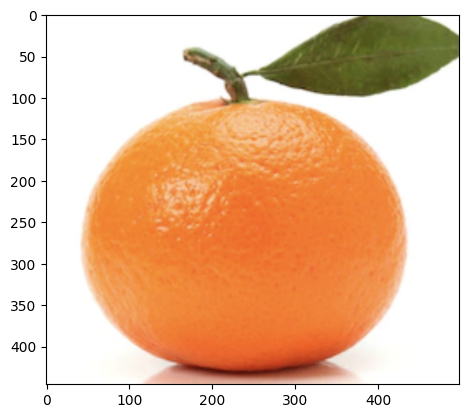

In [ ]:
'''make_predictions('fruits/valid/freshoranges/Screen Shot 2018-06-12 at 11.50.14 PM.png')'''


now i will create an array for the categories and print the prediction according to the highest score in the array

In [ ]:
class_labels = ["Fresh Apple", "Fresh Banana", "Rotten Apple", "Rotten Banana", "Fresh Orange", "Rotten Orange"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted class: Rotten Orange


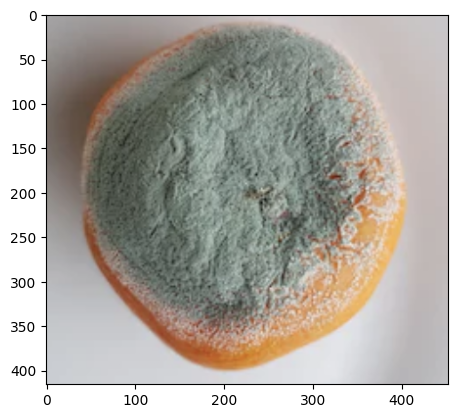

In [ ]:
import numpy as np
prediction = make_predictions('fruits/valid/rottenoranges/Screen Shot 2018-06-12 at 11.21.22 PM.png')
predicted_class_index = np.argmax(prediction)
predicted_label = class_labels[predicted_class_index]
print("Predicted class:", predicted_label)

## Discussion

Im going to analyze and discuss the results before and after unfreezing:

Analysis:

Before Unfreezing:

-->The model started with lower accuracy and high loss and then showed steady improvement 

--> The training accuracy started at 75% and gradually increased to 100% in later epochs

--> The validation accuracy was unsteady in the early epochs but improved to 87.5% by the last epoch

-->  The loss started high and gradually decreased but the validation loss satyed incosistant. 

Discussion: 

-->It is showing ovefitting signs as the training accuracy was 100% and the validation accuracy was lower

After Anfreezing:

--> The model shows rapid and significant improvement 

--> Training accuracy reaches 100% quickly

--> Validation accuracy increased to 100% in some epochs but shows unstability in other epochs 

--> The loss decreased to near zero in training while validation loss varied slightly but remained low

Discussion:

--> The improvement suggests that unfreezing helped the model learn usful features, the breif unstability in validation accuracy and loss indicates possible minor overfitting 





Conclusion:

the model improved significantly after unfreezing but it still shows signs of overfitting and validation unstability.

note: I noticed that there is no data in the valid/freshbanana and valid/rottenbananas and the overall validation data is small so increasing the testing set may improve the model performance 